# Generation for NLP Baseline Code

## Install Packages

In [77]:
!pip install -r requirements.txt

## Import Necessary Libraries

In [78]:
import torch
import transformers
from ast import literal_eval
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM, SFTConfig
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from datasets import Dataset
import json
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import evaluate
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from peft import AutoPeftModelForCausalLM, LoraConfig

import os
from huggingface_hub import login

pd.set_option('display.max_columns', None)

with open("../.env", "r") as f:
    token = f.read().strip() 
os.environ['HUGGINGFACE_TOKEN'] = token

In [79]:
# 난수 고정
def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)

set_seed(42) # magic number :)

## EDA

### Load Data

In [80]:
data_path = '../data/'
train_data_path = data_path + "train.csv"
test_data_path = data_path + "test.csv"

In [81]:
# Load the train dataset
# TODO Train Data 경로 입력
dataset = pd.read_csv(train_data_path) 

# Flatten the JSON dataset
records = []
for _, row in dataset.iterrows():
    problems = literal_eval(row['problems'])
    record = {
        'id': row['id'],
        'paragraph': row['paragraph'],
        'question': problems['question'],
        'choices': problems['choices'],
        'answer': problems.get('answer', None),
        "question_plus": problems.get('question_plus', None),
    }
    # Include 'question_plus' if it exists
    if 'question_plus' in problems:
        record['question_plus'] = problems['question_plus']
    records.append(record)
        
# Convert to DataFrame
df = pd.DataFrame(records)

In [82]:
df.head()

,id,paragraph,question,choices,answer,question_plus
0,generation-for-nlp-425,"상소하여 아뢰기를 , “신이 좌참 찬 송준길이 올린 차자를 보았는데 , 상복(喪服)...",상소한 인물이 속한 붕당에 대한 설명으로 옳은 것만을 모두 고르면?,"[ㄱ, ㄴ, ㄱ, ㄷ, ㄴ, ㄹ, ㄷ, ㄹ]",2,None
1,generation-for-nlp-426,"(가)은/는 의병계열과 애국계몽 운동 계열의 비밀결사가 모여 결성된 조직으로, 총사...",(가)에 대한 설명으로 옳지 않은 것은?,"[고려 문종 때에 남경(南京)으로 승격되었다., 종루(鐘樓), 이현, 칠패 등에서 ...",1,None
2,generation-for-nlp-427,나는 삼한(三韓) 산천의 음덕을 입어 대업을 이루었다.(가)는/은 수덕(水德)이 순...,(가) 지역에 대한 설명으로 옳은 것은?,"[이곳에 대장도감을 설치하여 재조대장경을 만들었다., 지눌이 이곳에서 수선사 결사운...",4,None
3,generation-for-nlp-428,이 날 소정방이 부총관 김인문 등과 함께 기 벌포에 도착하여 백제 군사와 마주쳤다....,밑줄 친 ‘그’에 대한 설명으로 옳은 것은?,"[살수에서 수의 군대를 물리쳤다 ., 김춘추 의 신라 왕위 계승을 지원하였다 ., ...",2,None
4,generation-for-nlp-429,"선비들 수만 명이 대궐 앞에 모여 만 동묘와 서원을 다시 설립할 것을 청하니, (가...",(가) 인물이 추진한 정책으로 옳지 않은 것은?,"[사창제를 실시하였다 ., 대전회통을 편찬하였다 ., 비변사의 기능을 강화하였다 ....",3,None


### Print missing values

In [83]:
# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
id                  0
paragraph           0
question            0
choices             0
answer              0
question_plus    2031
dtype: int64


### Basic information about the dataset

In [84]:
print("\nDataset Information:")
df.info()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2031 entries, 0 to 2030
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             2031 non-null   object
 1   paragraph      2031 non-null   object
 2   question       2031 non-null   object
 3   choices        2031 non-null   object
 4   answer         2031 non-null   int64 
 5   question_plus  0 non-null      object
dtypes: int64(1), object(5)
memory usage: 95.3+ KB


### EDA on 'question' and 'choices'

In [85]:
# Combine 'question' and 'question_plus' if available
df['question_plus'] = df['question_plus'].fillna('')
df['full_question'] = df.apply(lambda x: x['question'] + ' ' + x['question_plus'] if x['question_plus'] else x['question'], axis=1)

# Calculate the length of each question
df['question_length'] = df['full_question'].apply(len)

### Question Length Distribution

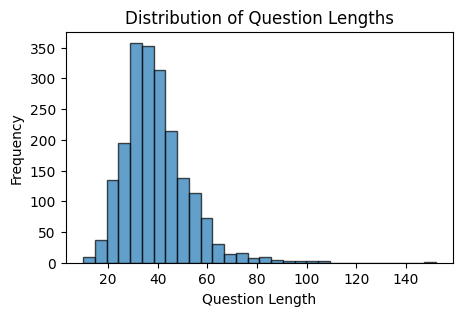

In [86]:
plt.figure(figsize=(5, 3))
plt.hist(df['question_length'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Question Lengths')
plt.xlabel('Question Length')
plt.ylabel('Frequency')
plt.show()

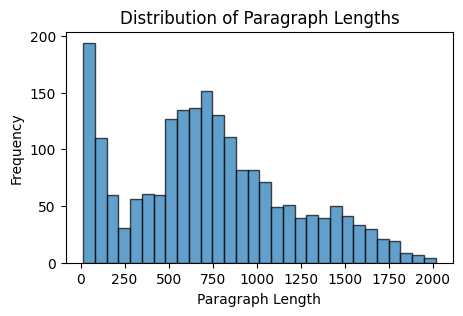

 paragarph length <= 1024: 1535
 paragarph length > 1024: 496
 min paragarph length: 15
 max paragarph length: 2017


In [87]:
p = 1024
plt.figure(figsize=(5, 3))
plt.hist(df['paragraph'].map(len), bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Paragraph Lengths')
plt.xlabel('Paragraph Length')
plt.ylabel('Frequency')
plt.show()
print(f" paragarph length <= {p}:", len(df[df['paragraph'].map(len) <= p]))
print(f" paragarph length > {p}:", len(df[df['paragraph'].map(len) > p]))
print(" min paragarph length:", df['paragraph'].map(len).min())
print(" max paragarph length:", df['paragraph'].map(len).max())

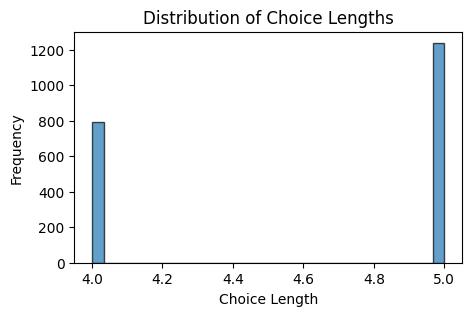

In [88]:
plt.figure(figsize=(5, 3))
plt.hist(df['choices'].map(len), bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Choice Lengths')
plt.xlabel('Choice Length')
plt.ylabel('Frequency')
plt.show()

## Feature Engineering using TF-IDF

- TF-IDF 참고 링크: https://ko.wikipedia.org/wiki/Tf-idf

### Initialize TF-IDF Vectorizer

In [89]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

### Fit and transform the text data

In [90]:
tfidf_matrix = tfidf_vectorizer.fit_transform(df['full_question'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

### Display the TF-IDF features

In [91]:
print("\nTF-IDF Features:")
display(tfidf_df.head(20))


TF-IDF Features:


11월  12월  1450  1450년에서  1750  1750년  17세기  1800년대  1860년  1960년대  1999년  \
0   0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
1   0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
2   0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
3   0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
4   0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
5   0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
6   0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
7   0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
8   0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
9   0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
10  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
11  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
12  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
13  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
14  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
15  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
16  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
17  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
18  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   
19  0.0  0.0   0.0      0.0   0.0    0.0   0.0     0.0    0.0     0.0    0.0   

    19세기  1분기   1월   1위  1위를   1의  2008년  2010년  2013년  2014  2014년  2014년도  \
0    0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
5    0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
6    0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
7    0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
8    0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
9    0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
10   0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
11   0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
12   0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
13   0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
14   0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
15   0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
16   0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
17   0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
18   0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   
19   0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   0.0    0.0     0.0   

    2015학년도  2019  2019년  2020  2020년  20세기  2분기  2에서  3분기   5년   5월  600  \
0       0.0   0.0    0.0   0.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1       0.0   0.0    0.0   0.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2       0.0   0.0    0.0   0.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3       0.0   0.0    0.0   0.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4       0.0   0.0    0.0   0.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
5       0.0   0.0    0.0   0.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
6       0.0   0.0    0.0   0.0    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   
7       0.0   0.0    0.0   0.0    0.0   0.0  0.

## Model Training

### Baseline Model

- https://huggingface.co/beomi/gemma-ko-2b

In [92]:
# 본인의 Huggingface auth token 입력
## Jupyter lab에서 로그인 하는 textbox가 나오지 않을 경우, terminal에서 로그인 하실 수 있습니다.
#!huggingface-cli login

모델과 토크나이저를 불러옵니다.

In [93]:
model = AutoModelForCausalLM.from_pretrained(
    "beomi/gemma-ko-2b",
    torch_dtype=torch.float16,
    trust_remote_code=True,
)
tokenizer = AutoTokenizer.from_pretrained(
    "beomi/gemma-ko-2b",
    trust_remote_code=True,
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

gemma-ko-2b 모델에는 chat template 이 없기 때문에 직접 입력해주어야 합니다.

In [94]:
tokenizer.chat_template = "{% if messages[0]['role'] == 'system' %}{% set system_message = messages[0]['content'] %}{% endif %}{% if system_message is defined %}{{ system_message }}{% endif %}{% for message in messages %}{% set content = message['content'] %}{% if message['role'] == 'user' %}{{ '<start_of_turn>user\n' + content + '<end_of_turn>\n<start_of_turn>model\n' }}{% elif message['role'] == 'assistant' %}{{ content + '<end_of_turn>\n' }}{% endif %}{% endfor %}"

### Prepare LoRA

In [95]:
peft_config = LoraConfig(
    r=6,
    lora_alpha=8,
    lora_dropout=0.05,
    target_modules=['q_proj', 'k_proj'],
    bias="none",
    task_type="CAUSAL_LM",
)

### Data Processing

In [96]:
dataset = Dataset.from_pandas(df)

In [97]:
PROMPT_NO_QUESTION_PLUS = """지문:
{paragraph}

질문:
{question}

선택지:
{choices}

1, 2, 3, 4, 5 중에 하나를 정답으로 고르세요.
정답:"""

PROMPT_QUESTION_PLUS = """지문:
{paragraph}

질문:
{question}

<보기>:
{question_plus}

선택지:
{choices}

1, 2, 3, 4, 5 중에 하나를 정답으로 고르세요.
정답:"""

In [98]:
dataset

Dataset({
    features: ['id', 'paragraph', 'question', 'choices', 'answer', 'question_plus', 'full_question', 'question_length'],
    num_rows: 2031
})

In [99]:
processed_dataset = []
for i in range(len(dataset)):
    choices_string = "\n".join([f"{idx + 1} - {choice}" for idx, choice in enumerate(dataset[i]["choices"])])

    # <보기>가 있을 때
    if dataset[i]["question_plus"]:
        user_message = PROMPT_QUESTION_PLUS.format(
            paragraph=dataset[i]["paragraph"],
            question=dataset[i]["question"],
            question_plus=dataset[i]["question_plus"],
            choices=choices_string,
        )
    # <보기>가 없을 때
    else:
        user_message = PROMPT_NO_QUESTION_PLUS.format(
            paragraph=dataset[i]["paragraph"],
            question=dataset[i]["question"],
            choices=choices_string,
        )

    # chat message 형식으로 변환
    processed_dataset.append(
        {
            "id": dataset[i]["id"],
            "messages": [
                {"role": "system", "content": "지문을 읽고 질문의 답을 구하세요."},
                {"role": "user", "content": user_message},
                {"role": "assistant", "content": f"{dataset[i]['answer']}"}
            ],
            "label": dataset[i]["answer"],
        }
    )


In [100]:
processed_dataset[0]

{'id': 'generation-for-nlp-425',
 'messages': [{'role': 'system', 'content': '지문을 읽고 질문의 답을 구하세요.'},
  {'role': 'user',
   'content': '지문:\n상소하여 아뢰기를 , “신이 좌참 찬 송준길이 올린 차자를 보았는데 , 상복(喪服) 절차에 대하여 논한 것이 신과는 큰 차이가 있었습니다 . 장자를 위하여 3년을 입는 까닭은 위로 ‘정체(正體)’가 되기 때문이고 또 전 중(傳重: 조상의 제사나 가문의 법통을 전함)하기 때문입니다 . …(중략) … 무엇보다 중요한 것은 할아버지와 아버지의 뒤를 이은 ‘정체’이지, 꼭 첫째이기 때문에 참 최 3년 복을 입는 것은 아닙니다 .”라고 하였다 .－현종실록 －ㄱ.기 사환국으로 정권을 장악하였다 .ㄴ.인 조반정을 주도 하여 집권세력이 되었다 .ㄷ.정조 시기에 탕평 정치의 한 축을 이루었다 .ㄹ.이 이와 성혼의 문인을 중심으로 형성되었다.\n\n질문:\n상소한 인물이 속한 붕당에 대한 설명으로 옳은 것만을 모두 고르면?\n\n선택지:\n1 - ㄱ, ㄴ\n2 - ㄱ, ㄷ\n3 - ㄴ, ㄹ\n4 - ㄷ, ㄹ\n\n1, 2, 3, 4, 5 중에 하나를 정답으로 고르세요.\n정답:'},
  {'role': 'assistant', 'content': '2'}],
 'label': 2}

In [101]:
processed_dataset = Dataset.from_pandas(pd.DataFrame(processed_dataset))
processed_dataset

Dataset({
    features: ['id', 'messages', 'label'],
    num_rows: 2031
})

In [102]:
def formatting_prompts_func(example):
    output_texts = []
    for i in range(len(example["messages"])):
        output_texts.append(
            tokenizer.apply_chat_template(
                example["messages"][i],
                tokenize=False,
            )
        )
    return output_texts

def tokenize(element):
    outputs = tokenizer(
        formatting_prompts_func(element),
        truncation=False,
        padding=False,
        return_overflowing_tokens=False,
        return_length=False,
    )
    return {
        "input_ids": outputs["input_ids"],
        "attention_mask": outputs["attention_mask"],
    }

# 데이터 토큰화
tokenized_dataset = processed_dataset.map(
    tokenize,
    remove_columns=list(processed_dataset.features),
    batched=True,
    num_proc=4,
    load_from_cache_file=False,
    desc="Tokenizing",
)

Tokenizing (num_proc=4):   0%|          | 0/2031 [00:00<?, ? examples/s]

In [103]:
#tokenized_dataset = tokenized_dataset.filter(lambda x: len(x["input_ids"]) )#<= 1024)  
#tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.1, seed=42)
print(type(tokenized_dataset))
print(tokenized_dataset)

<class 'datasets.arrow_dataset.Dataset'>
Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 2031
})


In [104]:
# 데이터 분리
# vram memory 제약으로 인해 인풋 데이터의 길이가 1024 초과인 데이터는 제외하였습니다. *힌트: 1024보다 길이가 더 긴 데이터를 포함하면 더 높은 점수를 달성할 수 있을 것 같습니다!
#tokenized_dataset = tokenized_dataset.filter(lambda x: len(x["input_ids"]))# <= 1024)  
tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.1, seed=42)

train_dataset = tokenized_dataset['train']
eval_dataset = tokenized_dataset['test']
# 데이터 확인
print(tokenizer.decode(train_dataset[0]["input_ids"], skip_special_tokens=True))

지문을 읽고 질문의 답을 구하세요.<start_of_turn>user
지문:
부산 강서구 김해공항 인근의 ‘공항마을’ 등 그린벨트(개발제한구역)에서 풀린 집단취락(마을) 지역에 상가나 공장을 지을 수 있게 된다. 또 임대주택을 35% 이상 의무적으로 짓도록 한 규제가 사실상 사라지는 등 그린벨트 내 규제가 대폭 완화된다. 국토교통부는 그린벨트 해제지역의 개발 사업을 활성화하기 위해 ‘개발제한구역의 조정을 위한 도시관리계획 변경안 수립 지침’ 및 ‘도시·군관리계획수립지침’을 이같이 개정해 11일부터 시행한다고 10일 발표했다. 개정된 지침은 그린벨트에서 풀린 집단취락이 시가지나 공항, 항만, 철도역 등 거점시설과 맞닿아 있는 경우 상가나 공장을 지을 수 있도록 했다. 기존에는 자연녹지지역이나 주거지역으로만 개발이 허용돼 정비사업이 지연됨에 따라 주민의 생활 불편을 초래한다는 지적을 반영했다. 김정희 국토부 녹색도시과장은 “전국 해제 취락 1656개(106㎢) 가운데 정비가 완료되거나 진행 중인 곳은 171개(10%)에 불과하다”며 “이제 부산 공항마을에도 김포공항 인근의 아울렛 같은 쇼핑시설이 들어설 수 있게 돼 정비사업에 속도가 붙을 것”이라고 말했다. 개정된 지침은 또 그린벨트에서 해제된 땅에 택지개발사업, 공공주택사업 등을 통해 주택을 지을 때 임대주택 용지가 6개월 넘게 팔리지 않으면 분양주택 용지로 바꿀 수 있도록 했다. 의무적으로 임대주택을 35% 이상 공급해야 하는 규정을 지키지 않아도 되는 것이다. 이럴 경우 창원 대전 등의 주택사업에 속도가 붙을 전망이다. 민간업체들의 개발 사업 참여를 장려하는 방안도 담겼다. 민간이 그린벨트 해제 대상 지역 개발을 위해 설립된 특수목적법인에 출자할 수 있는 비율을 2015년까지 한시적으로 종전 2분의 1 미만에서 3분의 2 미만으로 확대하기로 했다.

질문:
그린벨트 해제지역에서 상가나 공장을 지을 수 있도록 한 개정된 지침의 시행일은 언제인가?

선택지:
1 - 11일
2 - 10일
3 - 1일
4 - 12일

In [105]:
print(tokenizer.decode(train_dataset[0]["input_ids"], skip_special_tokens=False))

<bos>지문을 읽고 질문의 답을 구하세요.<start_of_turn>user
지문:
부산 강서구 김해공항 인근의 ‘공항마을’ 등 그린벨트(개발제한구역)에서 풀린 집단취락(마을) 지역에 상가나 공장을 지을 수 있게 된다. 또 임대주택을 35% 이상 의무적으로 짓도록 한 규제가 사실상 사라지는 등 그린벨트 내 규제가 대폭 완화된다. 국토교통부는 그린벨트 해제지역의 개발 사업을 활성화하기 위해 ‘개발제한구역의 조정을 위한 도시관리계획 변경안 수립 지침’ 및 ‘도시·군관리계획수립지침’을 이같이 개정해 11일부터 시행한다고 10일 발표했다. 개정된 지침은 그린벨트에서 풀린 집단취락이 시가지나 공항, 항만, 철도역 등 거점시설과 맞닿아 있는 경우 상가나 공장을 지을 수 있도록 했다. 기존에는 자연녹지지역이나 주거지역으로만 개발이 허용돼 정비사업이 지연됨에 따라 주민의 생활 불편을 초래한다는 지적을 반영했다. 김정희 국토부 녹색도시과장은 “전국 해제 취락 1656개(106㎢) 가운데 정비가 완료되거나 진행 중인 곳은 171개(10%)에 불과하다”며 “이제 부산 공항마을에도 김포공항 인근의 아울렛 같은 쇼핑시설이 들어설 수 있게 돼 정비사업에 속도가 붙을 것”이라고 말했다. 개정된 지침은 또 그린벨트에서 해제된 땅에 택지개발사업, 공공주택사업 등을 통해 주택을 지을 때 임대주택 용지가 6개월 넘게 팔리지 않으면 분양주택 용지로 바꿀 수 있도록 했다. 의무적으로 임대주택을 35% 이상 공급해야 하는 규정을 지키지 않아도 되는 것이다. 이럴 경우 창원 대전 등의 주택사업에 속도가 붙을 전망이다. 민간업체들의 개발 사업 참여를 장려하는 방안도 담겼다. 민간이 그린벨트 해제 대상 지역 개발을 위해 설립된 특수목적법인에 출자할 수 있는 비율을 2015년까지 한시적으로 종전 2분의 1 미만에서 3분의 2 미만으로 확대하기로 했다.

질문:
그린벨트 해제지역에서 상가나 공장을 지을 수 있도록 한 개정된 지침의 시행일은 언제인가?

선택지:
1 - 11일
2 - 10일
3 - 1일
4 

In [106]:
train_dataset_token_lengths = [len(train_dataset[i]["input_ids"]) for i in range(len(train_dataset))]
print(f"max token length: {max(train_dataset_token_lengths)}")
print(f"min token length: {min(train_dataset_token_lengths)}")
print(f"avg token length: {np.mean(train_dataset_token_lengths)}")

max token length: 1718
min token length: 142
avg token length: 708.9025725232622


In [107]:
eval_dataset_token_lengths = [len(eval_dataset[i]["input_ids"]) for i in range(len(eval_dataset))]
print(f"max token length: {max(eval_dataset_token_lengths)}")
print(f"min token length: {min(eval_dataset_token_lengths)}")
print(f"avg token length: {np.mean(eval_dataset_token_lengths)}")

max token length: 1510
min token length: 158
avg token length: 719.7941176470588


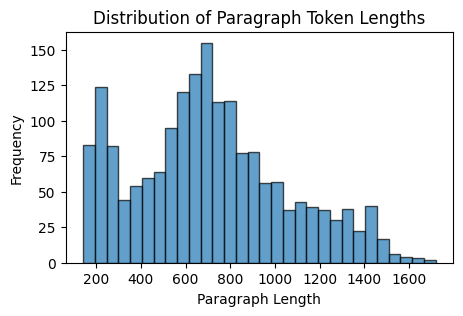

Filter:   0%|          | 0/1827 [00:00<?, ? examples/s]

 paragarph token length <= 1200: 1631


Filter:   0%|          | 0/1827 [00:00<?, ? examples/s]

 paragarph token length > 1200: 196


In [108]:
p = 1200
plt.figure(figsize=(5, 3))
plt.hist(train_dataset_token_lengths, bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Paragraph Token Lengths')
plt.xlabel('Paragraph Length')
plt.ylabel('Frequency')
plt.show()
print(f" paragarph token length <= {p}:", len(train_dataset.filter(lambda x:len(x['input_ids']) <= p)))
print(f" paragarph token length > {p}:", len(train_dataset.filter(lambda x:len(x['input_ids']) > p)))
#print(" min paragarph length:", df['paragraph'].map(len).min())
#print(" max paragarph length:", df['paragraph'].map(len).max())

In [109]:
print(tokenizer.chat_template)

{% if messages[0]['role'] == 'system' %}{% set system_message = messages[0]['content'] %}{% endif %}{% if system_message is defined %}{{ system_message }}{% endif %}{% for message in messages %}{% set content = message['content'] %}{% if message['role'] == 'user' %}{{ '<start_of_turn>user
' + content + '<end_of_turn>
<start_of_turn>model
' }}{% elif message['role'] == 'assistant' %}{{ content + '<end_of_turn>
' }}{% endif %}{% endfor %}
